<a href="https://colab.research.google.com/github/chelynl/Machine_Learning/blob/main/Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Random Forest

I will build multiple random forest models for different purposes (feature selection and prediction). The model building process is broken down into multiple parts shown below:

<b>Part 1:</b> Find Important Features Using Original Data<br>
<b>Part 2:</b> Subset Data to Include Only Important Features<br>
<b>Part 3:</b> Reduce Data Dimensions with PCA and Get Baseline RF<br>
<b>Part 4:</b> Tune Hyperparameters Using Convergence Plots, RandomSearch, GridSearch

Resources:<br>
https://github.com/WillKoehrsen/Data-Analysis/tree/master/random_forest_explained<br>
https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d<br>
https://towardsdatascience.com/optimizing-hyperparameters-in-random-forest-classification-ec7741f9d3f6

In [1]:
# Data Wrangling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
import seaborn as sns

# PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, MinMaxScaler, StandardScaler

# Modeling RF
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

# Accuracy metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, validation_curve

In [2]:
train_df = pd.read_csv('http://birch.iaa.ncsu.edu/~slrace/DataMining2021/Code/MLProject21_train.csv')
valid_df = pd.read_csv('http://birch.iaa.ncsu.edu/~slrace/DataMining2021/Code/MLProject21_valid.csv')
test_df = pd.read_csv('http://birch.iaa.ncsu.edu/~slrace/DataMining2021/Code/MLProject21_test.csv')

### EDA before any modeling

In [ ]:
train_df.head()

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20,v21,v22,v23,v24,v25,v26,v27,v28,v29,v30,v31,v32,v33,v34,v35,v36,v37,v38,v39,v40,...,v91,v92,v93,v94,v95,v96,v97,v98,v99,v100,v101,v102,v103,v104,v105,v106,v107,v108,v109,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119,v120,v121,v122,v123,v124,v125,v126,v127,cont.target,binary.target1,binary.target2
0,16.07,18.47,0.870060,-0.007407,-0.018315,-0.001862,False,-27.777778,59.714280,51.128020,70.586321,0.030,0.047280,30.867534,17.095155,28.714777,21.974035,0.016084,0.001958,54.157685,0.875643,0.845975,0.375000,0.726923,0.208814,-1.553774,1.060889,6.197893,0.000000,0.865385,-0.961538,-3.506558,-3.051664,59.714280,51.128020,70.586321,30.867534,-17.095155,28.714777,54.157685,...,-0.660144,34.730539,-0.695163,0.410577,0.627885,-1.160417,-1.427308,-1.721154,5.562500,20.870833,20.479904,0.39848,1.546202e+09,6.77,0.00,23.93,-0.01,18.27,0.00,5.66,0.15,0.0,140,0,0.9514,-0.0014,1887,4,1194,0,92,-2,3173,2,94.15,-0.05,3696.0,0.130,0,0
1,16.07,18.46,0.870531,-0.011074,-0.018382,-0.006179,False,-23.529412,61.048270,51.168539,73.781560,0.035,0.046403,30.743829,16.174140,31.053539,22.622571,0.018389,0.005244,56.363845,0.872853,0.827419,0.384578,0.746082,0.319360,-1.452192,1.147438,6.280302,0.096145,0.769157,-0.663398,-3.352407,-3.070391,61.048270,51.168539,73.781560,-30.743829,-16.174140,31.053539,56.363845,...,-0.660144,34.730539,-0.695163,0.506682,0.723969,-1.064160,-1.331026,-1.624844,5.658110,20.964971,20.574079,0.39848,1.546202e+09,6.76,-0.01,23.93,0.00,18.27,0.00,5.66,0.15,0.0,141,1,0.9526,0.0012,1891,4,1185,-9,99,7,3175,2,94.16,0.01,3697.0,0.120,0,0
2,15.98,18.37,0.869897,-0.007435,-0.018382,-0.003731,False,-5.882353,64.812654,51.289999,74.238744,0.040,0.045946,31.941279,15.168347,35.604045,23.549819,0.022085,0.008613,48.800293,0.926618,0.873030,0.602653,0.966936,0.617231,-1.158617,1.426086,6.553946,0.288351,1.441753,-0.096117,-3.218876,-3.080296,64.812654,51.289999,74.238744,31.941279,-15.168347,35.604045,48.800293,...,-0.660144,34.730539,-0.695163,0.794887,1.012111,-0.775503,-1.042291,-1.336025,5.944829,21.247277,20.856498,0.39848,1.546202e+09,6.77,0.01,23.95,0.02,18.28,0.01,5.67,0.15,0.0,141,0,0.9508,-0.0018,1895,4,1181,-4,100,1,3176,1,94.20,0.04,3698.0,0.090,0,0
3,15.96,18.37,0.868808,-0.012963,-0.016605,-0.009294,False,-41.176471,53.646082,51.035479,69.032397,0.065,0.047307,28.806442,18.209380,22.539351,23.477643,0.020920,0.011074,45.064402,0.748061,0.777115,-0.118292,0.308713,0.043758,-1.731992,0.840618,5.967478,-0.577034,0.673206,-0.961723,-2.733368,-3.051103,53.646082,51.035479,-69.032397,-28.806442,-18.209380,22.539351,-45.064402,...,-0.660144,34.730539,-0.695163,0.218311,0.435661,-1.352985,-1.619927,-1.913830,5.371225,20.682503,20.291498,0.39848,1.546202e+09,6.79,0.02,23.90,-0.05,18.23,-0.05,5.67,0.15,0.0,142,1,0.9496,-0.0012,1897,2,1178,-3,101,1,3176,0,94.20,0.00,3699.0,0.150,0,0
4,15.98,18.38,0.869423,-0.007407,-0.007407,-0.000373,False,-20.588235,58.173147,51.177162,68.061283,0.035,0.046428,27.255295,17.228856,22.539351,23.410622,0.022112,0.013282,48.608706,0.739102,0.854717,0.153824,0.598952,0.396898,-1.390737,1.167860,6.288853,0.336490,1.105610,-0.528770,-3.352407,-3.069860,-58.173147,51.177162,-68.061283,-27.255295,17.228856,-22.539351,-48.608706,...,-0.660144,34.730539,-0.695163,0.554728,0.772004,-1.016039,-1.282892,-1.576696,5.705908,21.012034,20.621160,0.39848,1.546202e+09,6.78,-0.01,23.88,-0.02,18.22,-0.01,5.66,0.15,0.0,142,0,0.9495,-0.0001,1884,-13,1197,19,95,-6,3176,0,94.20,0.00,3700.0,0.115,0,0


Identify Anomalies

In [ ]:
print('Data Dimensions: ', train_df.shape)

# look at column types and identify null values
train_df.info()

# We have 1 bool, 1 categorical, and the rest are numeric
# Let's explore whether we should one-hot encode the categorical var if it's useful

Data Dimensions:  (250000, 130)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Columns: 130 entries, v1 to binary.target2
dtypes: bool(1), float64(115), int64(13), object(1)
memory usage: 246.3+ MB


In [ ]:
train_df.dtypes[train_df.dtypes=='bool'] # v7 is bool type
train_df.dtypes[train_df.dtypes=='object'] # v45 is object type (categorical)

v45    object
dtype: object

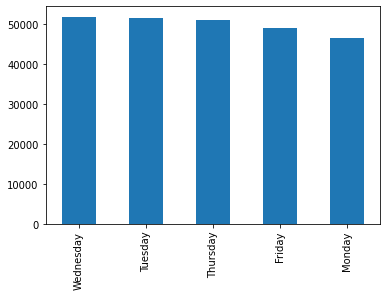

In [ ]:
# v7 has all False in training data (not useful for model training)
train_df['v7'].value_counts()

# v45 has evenly distributed levels (not useful)
train_df['v45'].value_counts()
train_df['v45'].value_counts().plot(kind='bar')

We will drop non-numeric variables that are not useful.



In [3]:
train_df.drop(['v7', 'v45'], axis=1, inplace=True)

Separate out inputs (attributes) and outputs (targets). We are focusing on binary target 2.

In [4]:
# Get inputs and outputs as separate dfs on training data
X_train = train_df.drop(['cont.target', 'binary.target1', 'binary.target2'], axis=1)
y_train = train_df['binary.target2']

# Repeat for validation data
X_valid = valid_df.drop(['v7', 'v45', 'cont.target', 'binary.target1', 'binary.target2'], axis=1)
y_valid = valid_df['binary.target2']

# Repeat for test data (targets not provided)
X_test = test_df.drop(['v7', 'v45'], axis=1)

# Convert input and output dfs to arrays for sklearn
train_features = np.array(X_train)
y_train = np.ravel(np.array(y_train))

# Repeat for validation data
valid_features = np.array(X_valid)
y_valid = np.ravel(np.array(y_valid))

# Repeat for test data
test_features = np.array(X_test)

# Save feature names for later use
feature_list = list(X_train.columns)

We will be focusing on binary target 2.

In [ ]:
print('Training Features Shape: ', train_features.shape)
print('Training Labels Shape ', y_train.shape)
print('Valid Features Shape ', valid_features.shape)
print('Valid Labels Shape ', y_valid.shape)

Training Features Shape:  (250000, 125)
Training Labels Shape  (250000,)
Valid Features Shape  (100000, 125)
Valid Labels Shape  (100000,)


Train Model

In [5]:
# Instantiate random forest using default parameters
clf = RandomForestClassifier(random_state=7)

# Train the model on training data
clf.fit(train_features, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)

Make predictions on validation data

In [6]:
# Get predictions on the validation data
y_pred = clf.predict(valid_features)

# View accuracy score
print('Accuracy Score: ', accuracy_score(y_valid, y_pred))

# View confusion matrix
confusion_matrix(y_valid, y_pred)

Accuracy Score:  0.79347


array([[75495,  7389],
       [13264,  3852]])

Variable Importance

In [7]:
# Quantify feature importance for each attribute
importance_metrics = list(clf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importance_metrics)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: v33                  Importance: 0.04
Variable: v13                  Importance: 0.03
Variable: v51                  Importance: 0.03
Variable: v1                   Importance: 0.02
Variable: v2                   Importance: 0.02
Variable: v101                 Importance: 0.02
Variable: v127                 Importance: 0.02
Variable: v3                   Importance: 0.01
Variable: v5                   Importance: 0.01
Variable: v6                   Importance: 0.01
Variable: v9                   Importance: 0.01
Variable: v10                  Importance: 0.01
Variable: v11                  Importance: 0.01
Variable: v12                  Importance: 0.01
Variable: v14                  Importance: 0.01
Variable: v15                  Importance: 0.01
Variable: v17                  Importance: 0.01
Variable: v18                  Importance: 0.01
Variable: v19                  Importance: 0.01
Variable: v22                  Importance: 0.01
Variable: v24                  Importanc

Model with Two Most Important Features

In [8]:
# New random forest with only the two most important variables
clf_most_important = RandomForestClassifier()

# Extract the two most important features: v33, v13
important_indices = [feature_list.index('v33'), feature_list.index('v13')]
train_important = train_features[:, important_indices]
valid_important = valid_features[:, important_indices]

# Train the random forest
clf_most_important.fit(train_important, y_train)

# Make predictions and determine the error
y_pred = clf_most_important.predict(valid_important)

# View accuracy score
print('Accuracy Score: ', accuracy_score(y_valid, y_pred))

# View confusion matrix
confusion_matrix(y_valid, y_pred)

Accuracy Score:  0.71633


array([[63902, 18982],
       [ 9385,  7731]])

Visualize feature importance

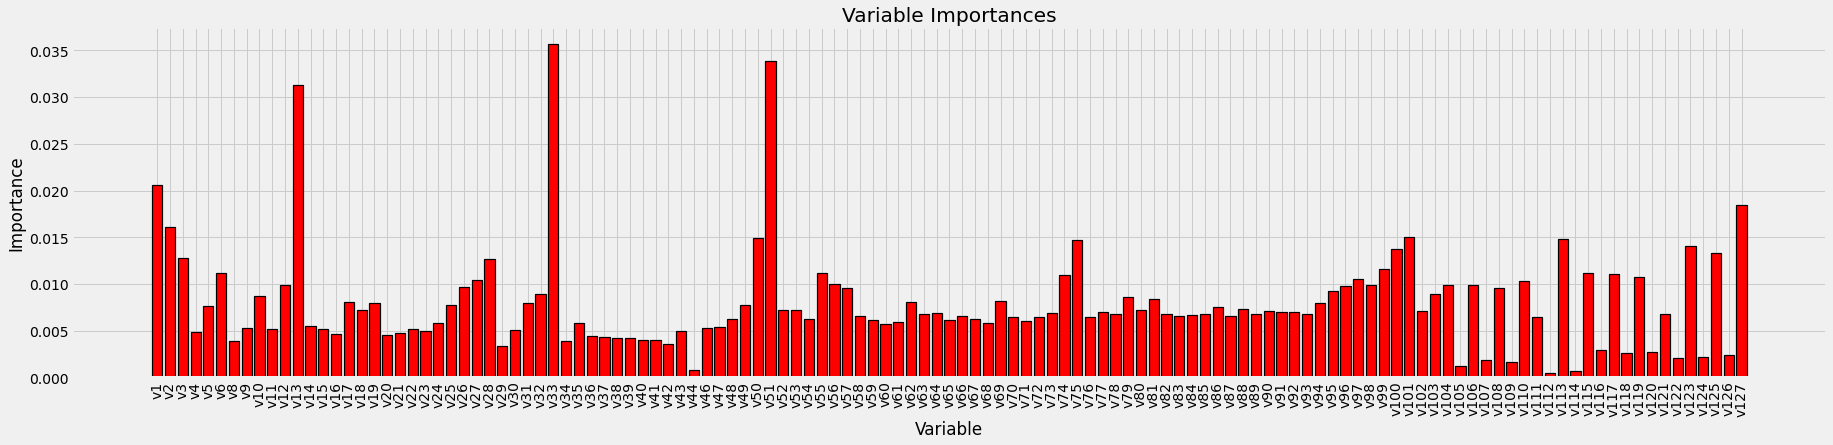

In [9]:
# Reset style 
plt.style.use('fivethirtyeight')
plt.figure(figsize=(28,6))

# list of x locations for plotting
x_values = list(range(len(importance_metrics)))

# Make a bar chart
plt.bar(x_values, importance_metrics, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)

# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

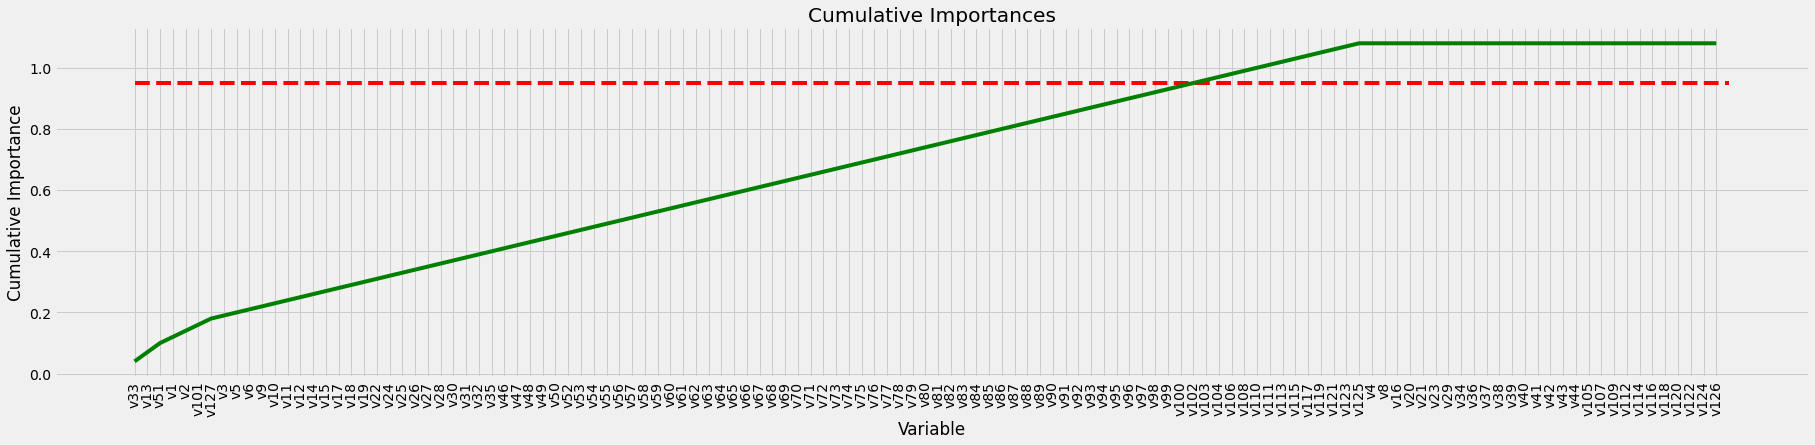

In [10]:
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances] # extract metric from list of tuples
sorted_features = [importance[0] for importance in feature_importances] # extract variable from list of tuples

# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)

# Make a line graph
plt.figure(figsize=(28,6))
plt.plot(x_values, cumulative_importances, 'g-')

# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')

# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')

# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');

# Limit the number of features

Reduce the number of features used by the model to only those required to account for 95% of the importance. The same number of features must be used in the training and testing sets.

In [ ]:
# Find number of features for cumulative importance of 95%
# Add 1 because Python is zero-indexed
print('Number of features for 95% importance:', np.where(cumulative_importances > 0.95)[0][0] + 1)

Number of features for 95% importance: 84


In [11]:
# Extract the names of the most important features
important_feature_names = [feature[0] for feature in feature_importances[0:84]]
# Find the columns of the most important features
important_indices = [feature_list.index(feature) for feature in important_feature_names]

# Create training and testing sets with only the important features
important_train_features = train_features[:, important_indices]
important_valid_features = valid_features[:, important_indices]

# Sanity check on operations
print('Important train features shape:', important_train_features.shape)
print('Important valid features shape:', important_valid_features.shape)

Important train features shape: (250000, 84)
Important valid features shape: (100000, 84)


Training on important features

In [12]:
# Train the expanded model on only the important features
clf.fit(important_train_features, y_train);

Evaluate on important features

In [13]:
# Make predictions and determine the error
y_pred = clf.predict(important_valid_features)

# View accuracy score
print('Accuracy Score: ', accuracy_score(y_valid, y_pred))

# View confusion matrix
confusion_matrix(y_valid, y_pred)

Accuracy Score:  0.81261


array([[77426,  5458],
       [13281,  3835]])

Decreasing the number of features actually increased performance in our case (this doesn't always happen but should still be done). However, in other situations, performance will decrease but run time will also decrease. The final decision on how many features to retain will therefore be a trade-off between accuracy and run time.

# Compare Trade-Offs

In [ ]:
# Use time library for run time evaluation
import time

# All features training and testing time
all_features_time = []

# Do 10 iterations and take average for all features
for _ in range(10):
    start_time = time.time()
    clf.fit(train_features, y_train)
    all_features_predictions = clf.predict(valid_features)
    end_time = time.time()
    all_features_time.append(end_time - start_time)

all_features_time = np.mean(all_features_time)
print('All features total training and testing time:', round(all_features_time, 2), 'seconds.')

All features total training and testing time: 445.84 seconds.


In [ ]:
# Time training and testing for reduced feature set
reduced_features_time = []

# Do 10 iterations and take average
for _ in range(10):
    start_time = time.time()
    clf.fit(important_train_features, y_train)
    reduced_features_predictions = clf.predict(important_valid_features)
    end_time = time.time()
    reduced_features_time.append(end_time - start_time)

reduced_features_time = np.mean(reduced_features_time)
print('Reduced features total training and testing time:', round(reduced_features_time, 2), 'seconds.')

Reduced features total training and testing time: 336.84 seconds.


Accuracy vs. Run Time

In [ ]:
all_accuracy =  accuracy_score(y_valid, all_features_predictions)
reduced_accuracy = accuracy_score(y_valid, reduced_features_predictions)

comparison = pd.DataFrame({'features': ['all (125)', 'reduced (84)'], 
                           'run_time': [round(all_features_time, 2), round(reduced_features_time, 2)],
                           'accuracy': [round(all_accuracy, 2), round(reduced_accuracy, 2)]})

comparison[['features', 'accuracy', 'run_time']]

,features,accuracy,run_time
0,all (125),0.79,445.84
1,reduced (84),0.81,336.84


In [ ]:
relative_accuracy_decrease = 100 * (all_accuracy - reduced_accuracy) / all_accuracy
print('Relative decrease in accuracy:', round(relative_accuracy_decrease, 3), '%.')

relative_runtime_decrease = 100 * (all_features_time - reduced_features_time) / all_features_time
print('Relative decrease in run time:', round(relative_runtime_decrease, 3), '%.')

Relative decrease in accuracy: -2.412 %.
Relative decrease in run time: 24.45 %.


Concluding graphs

In [ ]:
all_cm = confusion_matrix(y_valid, all_features_predictions)
reduced_cm = confusion_matrix(y_valid, reduced_features_predictions)

all_FP = all_cm.sum(axis=0) - np.diag(all_cm)
all_FN = all_cm.sum(axis=1) - np.diag(all_cm)
all_TP = np.diag(all_cm)
all_TN = all_cm.sum() - (all_FP + all_FN + all_TP)
all_FPR = all_FP[1]/(all_FP[1] + all_TN[0])


reduced_FP = reduced_cm.sum(axis=0) - np.diag(reduced_cm)
reduced_FN = reduced_cm.sum(axis=1) - np.diag(reduced_cm)
reduced_TP = np.diag(reduced_cm)
reduced_TN = reduced_cm.sum() - (reduced_FP + reduced_FN + reduced_TP)
reduced_FPR = reduced_FP[1]/(reduced_FP[1] + reduced_TN[0])


# Create a dataframe for comparison
model_comparison = pd.DataFrame({'model': ['original', 'reduced'], 
                                 'FPR':  [all_FPR, reduced_FPR],
                                 'accuracy': [all_accuracy, reduced_accuracy],
                                 'run_time (s)': [all_features_time, reduced_features_time]})

# Order the dataframe
model_comparison = model_comparison[['model', 'FPR', 'accuracy', 'run_time (s)']]

model_comparison

,model,FPR,accuracy,run_time (s)
0,original,0.657326,0.79347,445.842817
1,reduced,0.587324,0.81261,336.835613


Comparing Models

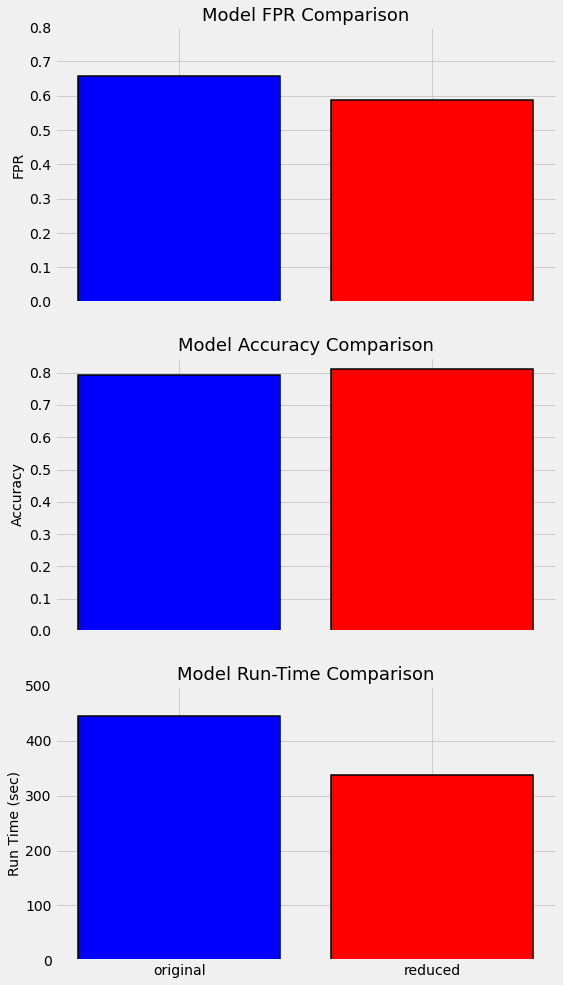

In [ ]:
# Make plots 
# Set up the plotting layout
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize = (8,16), sharex = True)

# Set up x-axis
x_values = [0, 1]
labels = list(model_comparison['model'])
plt.xticks(x_values, labels)

# Set up fonts
fontdict = {'fontsize': 18}
fontdict_yaxis = {'fontsize': 14}

# FPR Comparison
ax1.bar(x_values, model_comparison['FPR'], color = ['b', 'r'], edgecolor = 'k', linewidth = 1.5)
ax1.set_ylim(bottom = 0, top = 0.8)
ax1.set_ylabel('FPR', fontdict = fontdict_yaxis); 
ax1.set_title('Model FPR Comparison', fontdict= fontdict)

# Accuracy Comparison
ax2.bar(model_comparison['model'], model_comparison['accuracy'], color = ['b', 'r'], edgecolor = 'k', linewidth = 1.5)
ax2.set_ylim(bottom = 0, top = 0.85)
ax2.set_ylabel('Accuracy', fontdict = fontdict_yaxis); 
ax2.set_title('Model Accuracy Comparison', fontdict= fontdict)

# Run Time Comparison
ax3.bar(x_values, model_comparison['run_time (s)'], color = ['b', 'r'], edgecolor = 'k', linewidth = 1.5)
ax3.set_ylim(bottom = 0, top = 500)
ax3.set_ylabel('Run Time (sec)', fontdict = fontdict_yaxis); 
ax3.set_title('Model Run-Time Comparison', fontdict= fontdict);

From the comparison plots above, the reduced data is able to train the model faster with higher accuracy and a lower false positive rate. Thus, we will be moving forward with using the data only including important features.

In [14]:
# Get new dfs of important features only
train_imp_features = train_df[important_feature_names]
valid_imp_features = valid_df[important_feature_names]
test_imp_features = test_df[important_feature_names]

# Save new feature list for later use
feature_list = train_imp_features.columns.tolist()

train_imp_features.head()

,v33,v13,v51,v1,v2,v101,v127,v3,v5,v6,v9,v10,v11,v12,v14,v15,v17,v18,v19,v22,v24,v25,v26,v27,v28,v30,v31,v32,v35,v46,v47,v48,v49,v50,v52,v53,v54,v55,v56,v57,...,v62,v63,v64,v65,v66,v67,v68,v69,v70,v71,v72,v73,v74,v75,v76,v77,v78,v79,v80,v81,v82,v83,v84,v85,v86,v87,v88,v89,v90,v91,v92,v93,v94,v95,v96,v97,v98,v99,v100,v102
0,-3.051664,0.047280,0.120815,16.07,18.47,20.479904,3696.0,0.870060,-0.018315,-0.001862,59.714280,51.128020,70.586321,0.030,30.867534,17.095155,21.974035,0.016084,0.001958,0.845975,0.726923,0.208814,-1.553774,1.060889,6.197893,0.865385,-0.961538,-3.506558,51.128020,-46.341463,52.568705,49.319147,56.270184,0.15,18.405064,20.113414,4.435145,23.54983,-0.030547,-0.037055,...,-56.270184,-18.405064,-20.113414,-4.435145,44.147701,-0.595611,46.341463,0.030547,-34.730539,62.856359,59.306373,62.750245,0.41,0.52483,22.396407,13.975433,23.152454,31.37664,0.695163,0.715443,54.720354,0.660144,-62.856359,-59.306373,-62.750245,-22.396407,13.975433,-23.152454,-54.720354,-0.660144,34.730539,-0.695163,0.410577,0.627885,-1.160417,-1.427308,-1.721154,5.562500,20.870833,0.39848
1,-3.070391,0.046403,0.120815,16.07,18.46,20.574079,3697.0,0.870531,-0.018382,-0.006179,61.048270,51.168539,73.781560,0.035,30.743829,16.174140,22.622571,0.018389,0.005244,0.827419,0.746082,0.319360,-1.452192,1.147438,6.280302,0.769157,-0.663398,-3.352407,51.168539,-46.341463,52.568705,49.319147,56.270184,0.15,18.405064,20.113414,4.435145,23.54983,-0.030547,-0.037055,...,-56.270184,-18.405064,-20.113414,-4.435145,44.147701,-0.595611,46.341463,0.030547,-34.730539,62.856359,59.306373,62.750245,0.41,0.52483,22.396407,13.975433,23.152454,31.37664,0.695163,0.715443,54.720354,0.660144,-62.856359,-59.306373,-62.750245,-22.396407,13.975433,-23.152454,-54.720354,-0.660144,34.730539,-0.695163,0.506682,0.723969,-1.064160,-1.331026,-1.624844,5.658110,20.964971,0.39848
2,-3.080296,0.045946,0.120815,15.98,18.37,20.856498,3698.0,0.869897,-0.018382,-0.003731,64.812654,51.289999,74.238744,0.040,31.941279,15.168347,23.549819,0.022085,0.008613,0.873030,0.966936,0.617231,-1.158617,1.426086,6.553946,1.441753,-0.096117,-3.218876,51.289999,-46.341463,52.568705,49.319147,56.270184,0.15,18.405064,20.113414,4.435145,23.54983,-0.030547,-0.037055,...,-56.270184,-18.405064,-20.113414,-4.435145,44.147701,-0.595611,46.341463,0.030547,-34.730539,62.856359,59.306373,62.750245,0.41,0.52483,22.396407,13.975433,23.152454,31.37664,0.695163,0.715443,54.720354,0.660144,-62.856359,-59.306373,-62.750245,-22.396407,13.975433,-23.152454,-54.720354,-0.660144,34.730539,-0.695163,0.794887,1.012111,-0.775503,-1.042291,-1.336025,5.944829,21.247277,0.39848
3,-3.051103,0.047307,0.120815,15.96,18.37,20.291498,3699.0,0.868808,-0.016605,-0.009294,53.646082,51.035479,69.032397,0.065,28.806442,18.209380,23.477643,0.020920,0.011074,0.777115,0.308713,0.043758,-1.731992,0.840618,5.967478,0.673206,-0.961723,-2.733368,51.035479,-46.341463,52.568705,49.319147,56.270184,0.15,18.405064,20.113414,4.435145,23.54983,-0.030547,-0.037055,...,-56.270184,-18.405064,-20.113414,-4.435145,44.147701,-0.595611,46.341463,0.030547,-34.730539,62.856359,59.306373,62.750245,0.41,0.52483,22.396407,13.975433,23.152454,31.37664,0.695163,0.715443,54.720354,0.660144,-62.856359,-59.306373,-62.750245,-22.396407,13.975433,-23.152454,-54.720354,-0.660144,34.730539,-0.695163,0.218311,0.435661,-1.352985,-1.619927,-1.913830,5.371225,20.682503,0.39848
4,-3.069860,0.046428,0.120815,15.98,18.38,20.621160,3700.0,0.869423,-0.007407,-0.000373,58.173147,51.177162,68.061283,0.035,27.255295,17.228856,23.410622,0.022112,0.013282,0.854717,0.598952,0.396898,-1.390737,1.167860,6.288853,1.105610,-0.528770,-3.352407,51.177162,-46.341463,52.568705,49.319147,56.270184,0.15,18.405064,20.113414,4.435145,23.54983,-0.030547,-0.037055,...,-56.270184,-18.405064,-20.113414,-4.435145,44.147701,-0.595611,46.341463,0.030547,-34.730539,62.856359,59.306373,62.750245,0.41,0.52483,22.396407,13.975433,23.152454,31.37664,0.695163,0.715443,54.720354,0.660144,-62.856359,-59.306373,-

# Further Reduce Data with PCA

In [15]:
# scale to standardize training data
ss = StandardScaler()
ss.fit(train_imp_features)
train_norm = pd.DataFrame(ss.transform(train_imp_features), columns=feature_list)

# Define number of components to be used for PCA
pca = PCA(n_components=50)
scores = pca.fit_transform(train_norm)
loadings = pca.components_.T

# Convert scores array to df for first 50 PCs
# Create list of PCs to use for columns
comps = []
for i in range(1,51):
    comps.append("PC{}".format(i))

scores_df = pd.DataFrame(scores, columns=comps)
loadings_df = pd.DataFrame(loadings, columns=comps)

scores_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50
0,-0.716278,-0.393038,-2.913827,1.327546,-3.708707,-0.275258,-0.332058,0.135746,-0.058791,-0.074325,1.835031,0.124392,-1.928200,1.013445,0.107074,-0.030411,-0.886415,0.193578,-0.983166,0.595641,0.094106,0.172832,0.098802,0.002063,-0.131685,-0.718376,0.129302,0.583248,-0.203633,0.427559,-0.340299,-0.215762,0.523078,-0.909911,0.358486,-0.351970,0.271011,-0.443346,-0.035334,-0.134783,-0.726530,0.168542,0.464333,0.384122,0.028442,-0.350192,-0.598669,0.409418,-0.164267,-0.218168
1,-0.789522,-0.274916,-2.898668,1.387994,-3.746147,-0.277367,-0.381146,0.117043,-0.011849,-0.078226,1.810488,0.114764,-1.920563,1.036838,0.190263,-0.029021,-0.865954,0.227057,-0.887760,0.664568,0.066000,0.185399,0.023032,-0.018218,-0.162085,-0.749938,0.171004,0.597529,-0.125043,0.420328,-0.473019,-0.217296,0.494849,-0.956363,0.413335,-0.361762,0.259190,-0.488161,-0.037501,-0.144713,-0.697958,0.155825,0.521257,0.425993,0.024902,-0.344942,-0.462624,0.456793,-0.198587,-0.153265
2,-1.025355,0.038491,-2.940627,1.447336,-3.944000,-0.165607,-0.716753,0.028118,0.053431,-0.110358,1.719820,0.116547,-1.864522,1.109516,0.221719,-0.028162,-0.885631,0.243220,-0.755598,0.737382,0.038072,0.201818,0.065469,0.020095,-0.088449,-0.752554,0.122602,0.478724,-0.187633,0.456553,-0.447030,-0.222476,0.564431,-0.969488,0.357260,-0.347819,0.278684,-0.547018,-0.072204,-0.151267,-0.672047,0.129327,0.556176,0.418921,-0.036432,-0.299882,-0.385740,0.530415,-0.176850,-0.085176
3,-0.425581,-0.527759,-2.599782,1.635921,-3.642685,-0.575581,0.029735,0.021973,0.264278,0.017959,1.425060,0.123598,-1.859238,1.175117,0.499714,-0.014859,-0.861754,0.519255,-0.477315,0.941361,-0.029663,0.134326,-0.116747,-0.026710,-0.189037,-0.597761,0.064428,0.646415,-0.134121,0.450822,-0.398634,-0.233884,0.417175,-1.011677,0.444293,-0.375485,0.112874,-0.613208,-0.232091,-0.220609,-0.775359,0.139363,0.313589,0.467062,0.068913,-0.531603,-0.209336,0.597973,-0.300984,-0.004264
4,-0.753574,-0.399877,-2.846855,1.319836,-3.732304,-0.393571,-0.232652,-0.034762,-0.100162,-0.049469,1.567772,0.182031,-1.857306,1.047254,0.088049,-0.025468,-0.948056,0.246617,-0.883141,0.654032,0.099884,0.137888,0.063486,0.001120,-0.133199,-0.618173,0.030619,0.611635,-0.219070,0.419133,-0.311737,-0.219880,0.491356,-0.953290,0.406872,-0.347988,0.214041,-0.504076,-0.143162,-0.131912,-0.683714,0.426041,0.372216,0.519561,0.159926,-0.393064,-0.404394,0.498862,-0.207131,-0.135442


In [16]:
# Explained Variance per PC
explained_variance = pca.explained_variance_ratio_

# Cumulative explained variance
cumulative_variance = np.cumsum(np.round(explained_variance, decimals=3))

# Combine df of PC, explained variance, cumulative variance
pc_df = pd.DataFrame(comps, columns=['PC'])
explained_variance_df = pd.DataFrame(explained_variance, columns=['Explained Variance'])
cumulative_variance_df = pd.DataFrame(cumulative_variance, columns=['Cumulative Variance'])
df_explained_variance = pd.concat([pc_df, explained_variance_df, cumulative_variance_df], axis=1)

df_explained_variance.head()

,PC,Explained Variance,Cumulative Variance
0,PC1,0.267579,0.268
1,PC2,0.142462,0.410
2,PC3,0.088507,0.499
3,PC4,0.043801,0.543
4,PC5,0.035313,0.578


Text(0, 0.5, 'Eigenvalue')

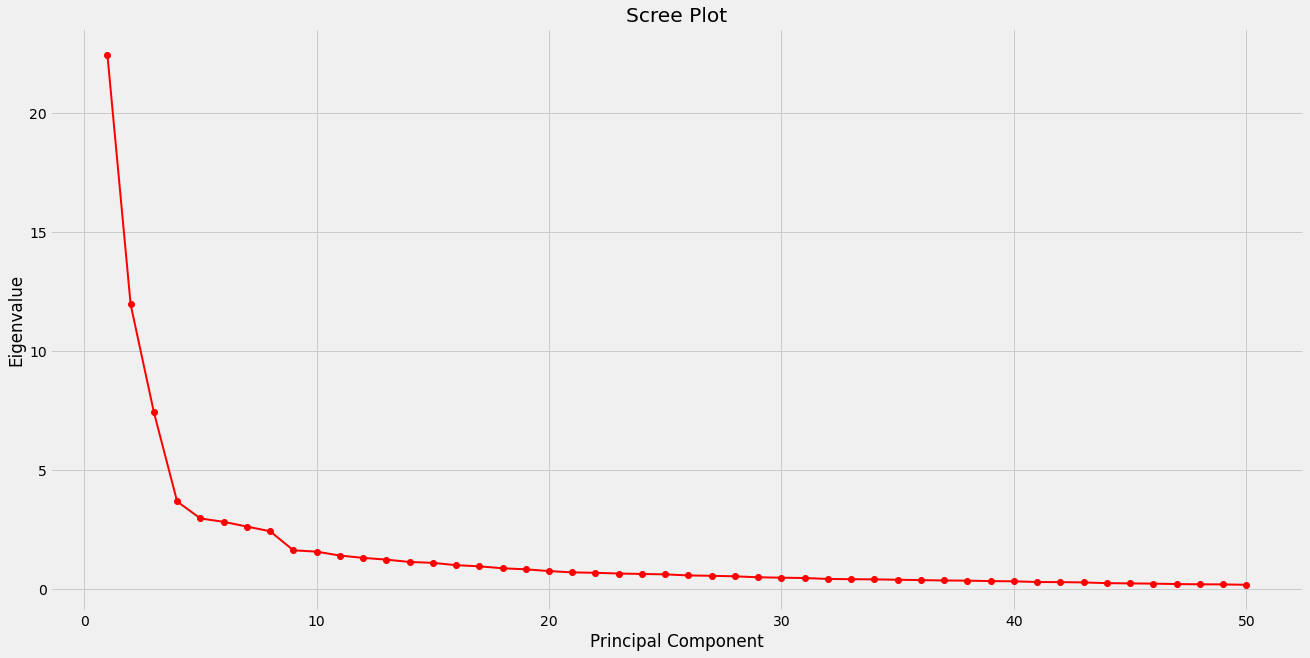

In [17]:
# Scree Plot-- first 10 PCs look good!
fig = plt.figure(figsize=(20,10))
PC_vals = np.arange(50) + 1
plt.plot(PC_vals, pca.explained_variance_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')

The first 10 PCs will be used to compress the training data.

In [18]:
# Reduce data dimension to 10 PCs
reduced_pca = PCA(n_components=10)
reduced_train = reduced_pca.fit_transform(train_norm)

# Create list of PCs for df
reduced_comps = []
for i in range(1,11):
    reduced_comps.append("PC{}".format(i))

# Assign reduced data of 10 PCs to new df
reduced_train = pd.DataFrame(reduced_train, columns=reduced_comps)
reduced_loadings = reduced_pca.components_.T

# Add target variable back to reduced data
reduced_train = pd.concat([reduced_train, train_df['binary.target2']], axis=1)
reduced_train.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,binary.target2
0,-0.716278,-0.393039,-2.913790,1.327114,-3.709238,-0.275011,-0.333185,0.134998,-0.069804,-0.061819,0
1,-0.789522,-0.274918,-2.898631,1.387656,-3.746905,-0.277092,-0.382359,0.116041,-0.023589,-0.063855,0
2,-1.025355,0.038490,-2.940580,1.447195,-3.944556,-0.164877,-0.717943,0.027327,0.043473,-0.098650,0
3,-0.425581,-0.527763,-2.599719,1.636130,-3.642958,-0.573799,0.028338,0.021084,0.252722,0.024061,0
4,-0.753574,-0.399878,-2.846811,1.319597,-3.732505,-0.392911,-0.233760,-0.035505,-0.110201,-0.040684,0


Repeat the same standardization steps for <b>validation</b> and <b>test</b> data for evaluating the final model. 
***
### When standardizing the validation data:
- use mean and standard deviation of <b>training</b> data to standardize validation data
- use loadings from training data to reduce validation data
***
### When standardizing the test data:
- combine the training and validation data first
- use mean and standard deviation of <b>training + validation</b> to standardize test data
- use loadings from training+validation to reduce test data

In [19]:
# standardize validation data using training mean and std
valid_norm = (valid_imp_features - train_imp_features.mean(axis=0))/train_imp_features.std(axis=0)
v_scale = np.array(valid_norm)

# get 10 PCs using training loadings
reduced_valid = pd.DataFrame(np.matmul(v_scale, reduced_loadings), columns=reduced_comps)
reduced_valid.head()

# Add target back to reduced data
reduced_valid = pd.concat([reduced_valid, valid_df['binary.target2']], axis=1)
reduced_valid.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,binary.target2
0,1.396509,8.281447,0.582650,0.352779,-0.222796,2.235231,-0.524421,-0.352510,3.179579,-1.291898,0
1,1.081053,8.176930,0.152219,-0.295048,-0.053104,2.352540,-0.612619,-0.374098,2.327908,-1.414974,0
2,1.052361,8.314099,0.282191,-0.071456,-0.169048,2.315915,-0.699884,-0.407470,2.539604,-1.397683,0
3,0.804089,8.772561,0.423639,0.276083,-0.460146,2.331705,-1.027382,-0.523814,2.920146,-1.397791,1
4,1.866121,7.766250,0.912464,0.562314,0.192686,1.666412,0.250090,-0.469595,3.340303,-1.217643,0


In [20]:
# Combine training and validation data into a single df (then convert to array)
train_valid = pd.concat([train_imp_features, valid_imp_features], axis=0)
train_valid_features = np.array(train_valid)

# scale to standardize training+validation data
ss = StandardScaler()
ss.fit(train_valid_features)
train_valid_norm = pd.DataFrame(ss.transform(train_valid_features), columns=feature_list)

# Reduce training+validation data dimension to 10 PCs
reduced_pca = PCA(n_components=10)
reduced_train_valid = reduced_pca.fit_transform(train_valid_norm)
reduced_train_valid = pd.DataFrame(reduced_train_valid, columns=reduced_comps)
train_valid_loadings = reduced_pca.components_.T

# Add target back to reduced data
y_train_valid = pd.concat([train_df, valid_df], axis=0)['binary.target2'].reset_index(drop=True)
reduced_train_valid = pd.concat([reduced_train_valid, y_train_valid], axis=1)

# standardize test data using training+validation mean and std
test_norm = (test_imp_features-train_valid_features.mean(axis=0))/train_valid_features.std(axis=0, dtype=np.float64)
test_scale = np.array(test_norm)

# get 10 PCs using training+validation loadings
reduced_test = pd.DataFrame(np.matmul(test_scale, train_valid_loadings), columns=reduced_comps)

Separate out inputs (attributes) and outputs (targets) for the new reduced data.

In [21]:
# Get inputs and outputs as separate dfs on training data
X_train = reduced_train.drop(['binary.target2'], axis=1)
y_train = reduced_train['binary.target2']

# Repeat for validation data
X_valid = reduced_valid.drop(['binary.target2'], axis=1)
y_valid = reduced_valid['binary.target2']

# Convert input and output dfs to arrays for sklearn
train_features = np.array(X_train)
y_train = np.ravel(np.array(y_train))

# Repeat for validation data
valid_features = np.array(X_valid)
y_valid = np.ravel(np.array(y_valid))

# Save feature names for later use
feature_list = list(X_train.columns)

AUC will be used as the main evaluation metric since our target is binary and AUC is good for binary classification problems.

In [22]:
# Evaluate function to see model results
def evaluate(model, test_features, test_labels):
  predictions = model.predict(test_features)
  accuracy = accuracy_score(test_labels, predictions)*100
  FPR, TPR, thresholds = roc_curve(test_labels, predictions)
  roc_auc = auc(FPR, TPR)
  print('Model Performance')
  print('AUC: ', roc_auc)
  print('Accuracy = {:0.2f}%.'.format(accuracy))

Perform logistic regression to see how much better (or worse) RF can do.

In [23]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

evaluate(logreg, X_valid, y_valid)

Model Performance
AUC:  0.6462602336843495
Accuracy = 83.23%.


Random Forest with Default Parameters as Base Model

In [24]:
# Fit RF with default parameters to get baseline idea of model performance
clf_base = RandomForestClassifier(random_state=45)
clf_base.fit(X_train, y_train)

evaluate(clf_base, X_valid, y_valid)

Model Performance
AUC:  0.6214151871650059
Accuracy = 81.64%.


Examine Default Parameters in Random Forest for Tuning

In [30]:
from pprint import pprint

# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(clf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': 10000,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 45,
 'verbose': 0,
 'warm_start': False}


# Hyperparameter Tuning

Multiple Methods:
1. Convergence Plots
2. Random Grid Search
3. Grid Search

<u>Important parameters for RF</u>
- `n_estimators`
  - using 2000+ trees can get computationally expensive
  - start with 4, 8, 16, 256, 512 trees and observe metrics 
- `max_features` (mtry)
  - max number of features per tree
- `max_depth`
  - how many levels deep per tree
- `min_samples_split`
  - min number of obs required in node to split it
  - increasing this leads to less splits and can prevent overfitting data
- `min_samples_leaf`
  - min number of samples required to be present in node after splitting

Convergence plot for <b>n_estimators</b>

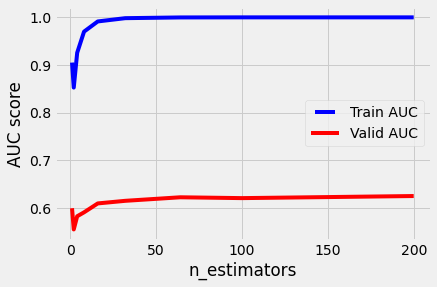

In [ ]:
# Potential candidates for n_estimators
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]


# Lists to store AUC scores from training and validation sets
train_results = []
valid_results = []


# Iterate over each candidate for n_estimators
for n in n_estimators:

  # Fit model on training data
  clf = RandomForestClassifier(n_estimators=n, n_jobs=-1)
  clf.fit(X_train, y_train)

  # Get training predictions
  train_pred = clf.predict(X_train)

  # Compute AUC from training and store in train_results
  FPR, TPR, thresholds = roc_curve(y_train, train_pred)
  roc_auc = auc(FPR, TPR)
  train_results.append(roc_auc)

  # Get validation predictions
  y_pred = clf.predict(X_valid)

  # Compute AUC from validation and store in valid results
  FPR, TPR, thresholds = roc_curve(y_valid, y_pred)
  roc_auc = auc(FPR, TPR)
  valid_results.append(roc_auc)


# Convergence plot
line1, = plt.plot(n_estimators, train_results, 'b', label = 'Train AUC')
line2, = plt.plot(n_estimators, valid_results, 'r', label = 'Valid AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

From the plot above, we can stop at 70 trees as increasing the number of trees does not seem to be increasing validation performance much further.

Convergence plot for <b>max_depth</b>

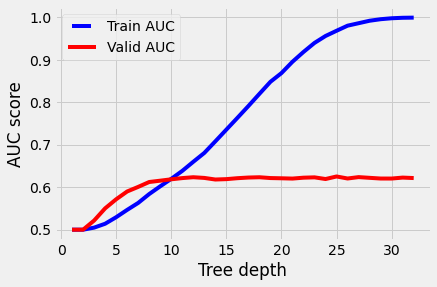

In [ ]:
# Potential candidates for max_depth
max_depths = np.linspace(1, 32, 32, endpoint=True)


# Lists to store AUC scores from training and validation sets
train_results = []
valid_results = []


# Iterate over each candidate for n_estimators
for md in max_depths:

  # Fit model on training data
  clf = RandomForestClassifier(max_depth=md, n_jobs=-1)
  clf.fit(X_train, y_train)

  # Get training predictions
  train_pred = clf.predict(X_train)

  # Compute AUC from training and store in train_results
  FPR, TPR, thresholds = roc_curve(y_train, train_pred)
  roc_auc = auc(FPR, TPR)
  train_results.append(roc_auc)

  # Get validation predictions
  y_pred = clf.predict(X_valid)

  # Compute AUC from validation and store in valid_results
  FPR, TPR, thresholds = roc_curve(y_valid, y_pred)
  roc_auc = auc(FPR, TPR)
  valid_results.append(roc_auc)

# Convergence plot
line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depths, valid_results, 'r', label='Valid AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

The plot above shows how the model overfits for large depth values but reaches a plateau in predicting the validation data around max_depth=10.

Convergence plot for <b>min_samples_split</b>

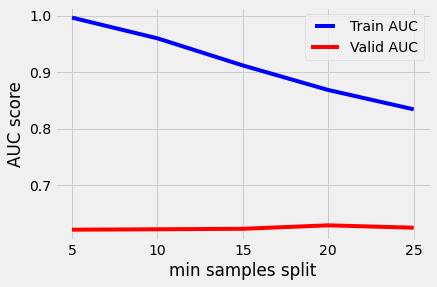

In [ ]:
# Potential candidates for min_samples_split
min_samples_splits = [5, 10, 15, 20, 25]


# Lists to store AUC scores from training and validation sets
train_results = []
valid_results = []


# Iterate over each candidate for min_samples_split
for mss in min_samples_splits:

  # Fit model on training data
  clf = RandomForestClassifier(min_samples_split=mss)
  clf.fit(X_train, y_train)

  # Get training predictions
  train_pred = clf.predict(X_train)

  # Compute AUC from training and store in train_results
  FPR, TPR, thresholds = roc_curve(y_train, train_pred)
  roc_auc = auc(FPR, TPR)
  train_results.append(roc_auc)

  # Get validation predictions
  y_pred = clf.predict(X_valid)

  # Compute AUC from validation and store in valid_results
  FPR, TPR, thresholds = roc_curve(y_valid, y_pred)
  roc_auc = auc(FPR, TPR)
  valid_results.append(roc_auc)


# Convergence plot
line1, = plt.plot(min_samples_splits, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_splits, valid_results, 'r', label='Valid AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples split')
plt.show()

Convergence plot for <b>min_samples_leaf</b>

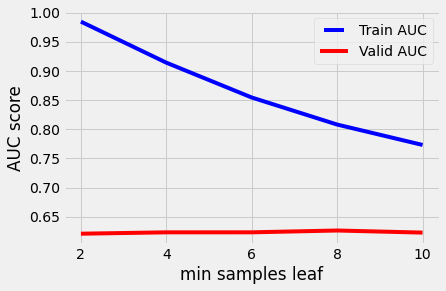

In [ ]:
# Potential candidates for min_samples_leaf
min_samples_leafs = [2, 4, 6, 8, 10]



# Lists to store AUC scores from training and validation sets
train_results = []
valid_results = []


# Iterate over each candidate for min_samples_split
for msl in min_samples_leafs:

  # Fit model on training data
  clf = RandomForestClassifier(min_samples_leaf=msl)
  clf.fit(X_train, y_train)

  # Get training predictions
  train_pred = clf.predict(X_train)

  # Compute AUC from training and store in train_results
  FPR, TPR, thresholds = roc_curve(y_train, train_pred)
  roc_auc = auc(FPR, TPR)
  train_results.append(roc_auc)

  # Get validation predictions
  y_pred = clf.predict(X_valid)

  # Compute AUC from validation and store in valid_results
  FPR, TPR, thresholds = roc_curve(y_valid, y_pred)
  roc_auc = auc(FPR, TPR)
  valid_results.append(roc_auc)


# Convergence plot
line1, = plt.plot(min_samples_leafs, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_leafs, valid_results, 'r', label='Valid AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples leaf')
plt.show()

Convergence plot for <b>max_features</b>

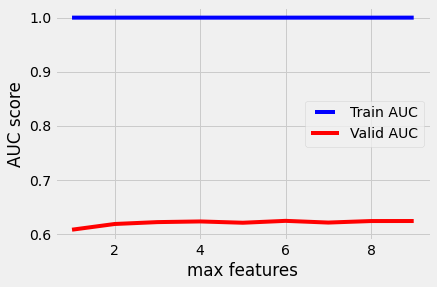

In [ ]:
# Potential candidates for max_features
max_features = list(range(1, X_train.shape[1]))


# Lists to store AUC scores from training and validation sets
train_results = []
valid_results = []


# Iterate over each candidate for max_features
for mf in max_features:

  # Fit model on training data
  clf = RandomForestClassifier(max_features=mf)
  clf.fit(X_train, y_train)

  # Get training predictions
  train_pred = clf.predict(X_train)

  # Compute AUC from training and store in train_results
  FPR, TPR, thresholds = roc_curve(y_train, train_pred)
  roc_auc = auc(FPR, TPR)
  train_results.append(roc_auc)

  # Get validation predictions
  y_pred = clf.predict(X_valid)

  # Compute AUC from validation and store in valid_results
  FPR, TPR, thresholds = roc_curve(y_valid, y_pred)
  roc_auc = auc(FPR, TPR)
  valid_results.append(roc_auc)


# Convergence plot
line1, = plt.plot(max_features, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_features, valid_results, 'r', label='Valid AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('max features')
plt.show()

This is an overfitting case. The AUC does not seem to change much regardless of the number of max features used.

Convergence plot for <b>criterion</b>

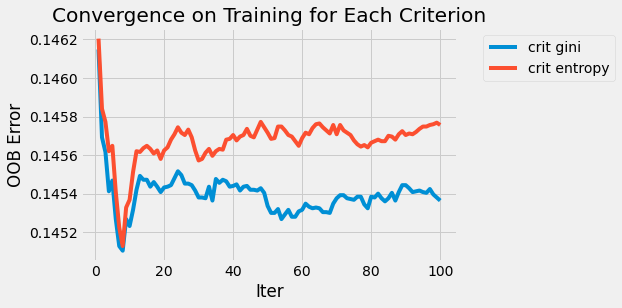

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# criterion candidates
crit = np.array(['gini', 'entropy'])

# create dict to store RFs
ensemble_clfs = {}

# iterate over potential max_depth values and keeping other parameters constant
for i in range(len(crit)):
  ensemble_clfs['crit {}'.format(crit[i])] = RandomForestClassifier(warm_start=True, 
                                                            oob_score=True, 
                                                            max_depth=md[0],
                                                            max_features=mf[0],
                                                            criterion=crit[i], 
                                                            random_state=45)

# Create list to be columns in the convergence df
iter =[]
crit_values = []
errors = []

for label, clf in ensemble_clfs.items():
  for n_estimator in range(1, 101):
    clf.set_params(n_estimators=n_estimator)
    clf.fit(X_train, y_train)
    
    # Add error and predictions to conv dict
    iter.append(n_estimator)
    crit_values.append(label)
    errors.append(1 - clf.oob_score_)
    # print(f'iter = {n_estimator}, {label}') # tracking loop

conv_crit = pd.DataFrame(list(zip(iter, crit_values, errors)), columns=['iter', 'criterion', 'error'])

sns.lineplot(x='iter', y='error', hue='criterion', data=conv_crit)
plt.title('Convergence on Training for Each Criterion')
plt.ylabel('OOB Error')
plt.xlabel('Iter')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')

In [25]:
# RF model using best parameters from convergence plots
clf_plots = RandomForestClassifier(n_estimators=70,
                             max_depth=10,
                             min_samples_split=20,
                             min_samples_leaf=8,
                             max_features=5,
                             criterion='gini',
                             random_state=45,
                             n_jobs=-1)

# Fit model to training data
clf_plots.fit(X_train, y_train)

# Model results
evaluate(clf_plots, X_valid, y_valid)

Model Performance
AUC:  0.6290497601205451
Accuracy = 83.01%.


To reduced time spent on grid search, you can set `bootstrap=True` and change `max_samples` (proportion of original data given per tree)

<u>General rule of thumb</u> 
1. Start with 10k observations and time the procedure
2. Double that to 20k (or halve it if it took too long)
3. Get 1-2 more data points (30k, 40k observations)
4. See time it took vs. number of observations plot

## Grid Search

Perform grid search on a range of hyperparameters around the best values returned by random search.

In [27]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

# Create a based model
clf = RandomForestClassifier(random_state=45, max_samples=10000)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, 
                           scoring = 'neg_mean_absolute_error', cv = 3, 
                           n_jobs = -1, verbose = 2)

In [ ]:
%%time
# Fit the grid search to the data (5h 15min 16s for 10k obs)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 55.0min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 128.6min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed: 233.5min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed: 315.1min finished


CPU times: user 18.9 s, sys: 786 ms, total: 19.7 s
Wall time: 5h 15min 16s


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=10000,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=45,
                                 

In [ ]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 80,
 'max_features': 2,
 'min_samples_leaf': 5,
 'min_samples_split': 12,
 'n_estimators': 200}

In [ ]:
best_grid = grid_search.best_estimator_

## Final Model

The final model has the following hyperparameters:

In [45]:
print('Model Parameters:\n')
pprint(best_grid.get_params())
print('\n')
# evaluate(best_grid, X_valid, y_valid)
evaluate(clf, X_valid, y_valid)

Model Parameters:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': 10000,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 45,
 'verbose': 0,
 'warm_start': False}


Model Performance
AUC:  0.622591718918589
Accuracy = 83.64%.
